### Load standard libraries



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from collections import Counter
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

from scipy.stats import linregress
from skimage.transform import rescale

### Load data
The data is Google Drive's fontclosgpu@gmail.com account. We **mount** the drive and untar the data in the ephemeral Google Colab instance we have been given.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Set basedir where we are going to operate

In [3]:
BASEDIR = Path("/content/drive/MyDrive/silicanets-data/")

We first read just the metadata, which has paths to images and targets. This is enough to do data resmapling to turn the target uniform and train validation test splitting.

### Set global parameters
Here we choose the number of runs, number of samples, max training epochs and dropout level.

In [4]:
# choose training dataset
training_data_disorder_variance = 0.2

if isinstance(training_data_disorder_variance, float):
  varcode = str(int(10 * training_data_disorder_variance))
  compressed_data = f"ml_dataset_var0{varcode}.tar.gz"
  compressed_data_fracture = f"ml_dataset_fracture_atoms_var0{varcode}.tar.gz"

elif training_data_disorder_variance == "variable":
  compressed_data = "ml_dataset_variable_var.tar.gz"
  compressed_data_fracture = f"ml_dataset_fracture_atoms_variable_var.tar.gz"

else:
  raise NotImplementedError


try:
  df = pd.read_csv("ml_dataset/metadata.csv")
except:
  ! tar xzf {BASEDIR / "data" / compressed_data}; tar xzf {BASEDIR / "data" / compressed_data_fracture} 
  df = pd.read_csv("ml_dataset/metadata.csv")
  

try:
  del history_df
except:
  pass

num_samples = "all" # a number or "all"
num_runs = "all" # a number or "all"
max_epochs = 25
dropout = 0
scale = 0.5

# for the lazy types
if num_samples == "all":
  num_samples = len(df)
if num_runs == "all":
  num_runs = len(df.run.unique())

assert num_runs <= len(df.run.unique())


In [5]:
if training_data_disorder_variance == "variable":
  disorder_df = pd.read_csv(BASEDIR / "data" / "variable_disorder_missing_metadata_column.txt", header=None, sep=" ", names=["run", "disorder"])
  disorder_df["run"] = disorder_df.run.apply(lambda x: f"run_{x:05d}")
  df["disorder_var"] = df.run.map(dict(disorder_df.values))

### Subsample data
Because the distribution of failure strain is approx gaussian, the model tends to predict average failure strain (similar to class imbalance problem). Given that we have access to unlimited amounts of data (in the form of data augmentation but if needed we could also run more simulations), what we do is to select a different number of images from each run, in a way that the final density of target is closer to uniform.

First select a subset of runs, this is just to study the effect of number of runs on final accuracy

In [6]:
assert num_runs <= len(df.run.unique())
valid_runs = np.random.choice(df.run.unique(), size=num_runs, replace=False)
_idx = df.run.apply(lambda x: x in valid_runs)
df = df.loc[_idx].copy()

Then do the proper data-augmentation level subsampling to render the target uniform.

In [7]:
df_subsampled = df.sample(num_samples)

### Create output dir
Create a new, unique directory to store all outputs of this round.

In [8]:
import datetime
model_name = "resnet-fracture-atoms-" + datetime.datetime.now().isoformat().split(".")[0]
! mkdir -p {BASEDIR / "output" / model_name / "checkpoints"}
! mkdir -p {BASEDIR / "output" / model_name / "dataframes"}
! mkdir -p {BASEDIR / "output" / model_name / "figures"}




Save dfs for reproducibility

In [9]:
pd.to_pickle(df, BASEDIR / "output" / model_name / "dataframes" / "df.p")
pd.to_pickle(df_subsampled, BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")

In [10]:
num_runs = len(df_subsampled.run.unique())
num_images = len(df_subsampled)

In [11]:
info = {
    "model_name": model_name,
    "num_runs": num_runs,
    "num_images": num_images,
    "max_epochs": max_epochs,
    "dropout": dropout,
    "scale": scale,
    "disorder_variance": training_data_disorder_variance,
    "loss": "mse"
}

In [12]:
pd.Series(info).to_csv(BASEDIR / "output" / model_name / "model_info.csv")

In [13]:
info

{'disorder_variance': 0.2,
 'dropout': 0,
 'loss': 'mse',
 'max_epochs': 25,
 'model_name': 'resnet-fracture-atoms-2022-02-28T07:56:05',
 'num_images': 57984,
 'num_runs': 906,
 'scale': 0.5}

### Split data
We need to split the data into the standard train, validation, test sets, but respecting the original runs (otherwise we have copies of same run in different sets which is not ok)

In [14]:
def data_splitter(df, test_split=0.2):
  """Split the metadata dataframe into train and test sets
  keeping runs together, that is, not allowing different images
  of the same run to be in different sets.
  """
  runs_all = df["run"].unique()
  _run_splitter = int((1 - test_split) * len(runs_all))
  np.random.shuffle(runs_all)
  runs_train = runs_all[:_run_splitter]
  runs_test = runs_all[_run_splitter:]
  _idx_train = df.run.apply(lambda x: x in runs_train)
  _idx_test = df.run.apply(lambda x: x in runs_test)
  df_train = df.loc[_idx_train]
  df_test = df.loc[_idx_test]

  return df_train, df_test

In [15]:
df_train, df_test = data_splitter(df_subsampled, test_split = 0.2)
df_train, df_validation = data_splitter(df_train, test_split=0.1)


### Load images
We load all images into memory. 
So far this works, but we are close to our memory limits.
We might need to use keras DataGenerators in the future.

In [16]:
def get_xy_from_df(df, scale: float=1.0, noise=0):
    "ignores missing images in fracture dataset. must reconstruct df"
    X = []
    y = []
    new_df_dict = {}
    for idx, sample in df.iterrows():
        try:
          config_image = sample["image"]
          fracture_image = config_image.replace("images", "images_fracture_atoms").replace(".png", "") + "-fracture.png"
          _X = rescale(plt.imread(config_image), scale=scale)
          _y = rescale(plt.imread(fracture_image), scale=scale)
          _y += np.random.uniform(0, noise, size=_y.shape)
          X.append(_X)
          y.append(_y)
          new_df_dict[idx] = sample
        except:
          pass
    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, -1)
    y = np.expand_dims(y, -1)
    new_df = pd.DataFrame(new_df_dict).T
    return new_df, X, y

In [17]:
df_train, X_train, y_train = get_xy_from_df(df_train, scale=scale)
df_validation, X_validation, y_validation = get_xy_from_df(df_validation, scale=scale)
df_test, X_test, y_test = get_xy_from_df(df_test, scale=scale)

In [18]:
print(f"Saving metadata of train, test, validation for reproducibility:")
print(f"Train set: {len(df_train.run.unique())} runs ({len(df_train)} images)")
print(f"Validation set: {len(df_validation.run.unique())} runs ({len(df_validation)} images)")
print(f"Test set: {len(df_test.run.unique())} runs ({len(df_test)} images)")

df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
df_validation.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")

Saving metadata of train, test, validation for reproducibility:
Train set: 620 runs (39680 images)
Validation set: 67 runs (4288 images)
Test set: 173 runs (11072 images)


### Feature normalization
We rescale features using train test to learn the rescaling parameters, avoiding data leaking.

In [19]:
_m = np.mean(X_train, axis=0)
_s = np.std(X_train, axis=0)

X_train = ((X_train - _m) / _s)
X_validation = ((X_validation - _m) / _s)
X_test =  ((X_test - _m) / _s)

In [20]:
_m_global = min(y_train.reshape(-1))

y_train = y_train - _m_global
y_validation = y_validation - _m_global
y_test = y_test - _m_global

In [21]:
train_data_rescale_params = {
    "mean": _m,
    "std": _s,
    "target_min": _m_global
}
pd.to_pickle(train_data_rescale_params, BASEDIR / "output" / model_name / "dataframes" / "train_data_rescale_params.p")

In [22]:
pd.to_pickle(X_train, BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
pd.to_pickle(X_validation, BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
pd.to_pickle(X_test, BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

pd.to_pickle(y_train, BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
pd.to_pickle(y_validation, BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
pd.to_pickle(y_test, BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

### Crash recover
Uncomment this cell and run to recover from a crash after training.
Remember to skip training if you do this!

In [23]:
if False:
  model_name = ""

  df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df.p")
  df_subsampled = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")
  df_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
  df_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
  df_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")


  X_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
  X_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
  X_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

  y_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
  y_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
  y_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

  #history_df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df.p")

  # recover important settings
  info = dict(pd.read_csv(BASEDIR / "output" / model_name / "model_info.csv").values)
  dropout = float(info["dropout"])
  try:
    training_data_disorder_variance = float(info["disorder_variance"])
  except:
    training_data_disorder_variance = str(info["disorder_variance"])

else:
  print(f"last model I created was named {model_name}")


last model I created was named resnet-fracture-atoms-2022-02-28T07:56:05


### Model setup
We use a simple keras + dropout + dense scheme.

In [24]:
def get_model(activation="sigmoid", loss='binary_crossentropy'):

  premaid = tf.keras.applications.ResNet50(
    include_top = False,
    pooling = None,#prima era avg, ora voglio output last conv block
    weights = None,
    input_shape=(None, None, 1),
  )

  inputs = tf.keras.Input(shape=(128, 128, 1)) 

  resnet = premaid(inputs) # (4, 4, 2048)

  x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding='same')(resnet)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  
  x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  
  x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  
  x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  
  x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding='same')(x)
  
  x = tf.keras.layers.Conv2D(1, (3, 3), activation=activation, padding='same')(x)

  model = tf.keras.Model(inputs = inputs, outputs = x)

  model.compile(loss=loss, optimizer="adam")
  return model

In [25]:
model = get_model(activation="tanh", loss="mse")

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23581440  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         2359424   
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 64)       0         
 2D)                                                         

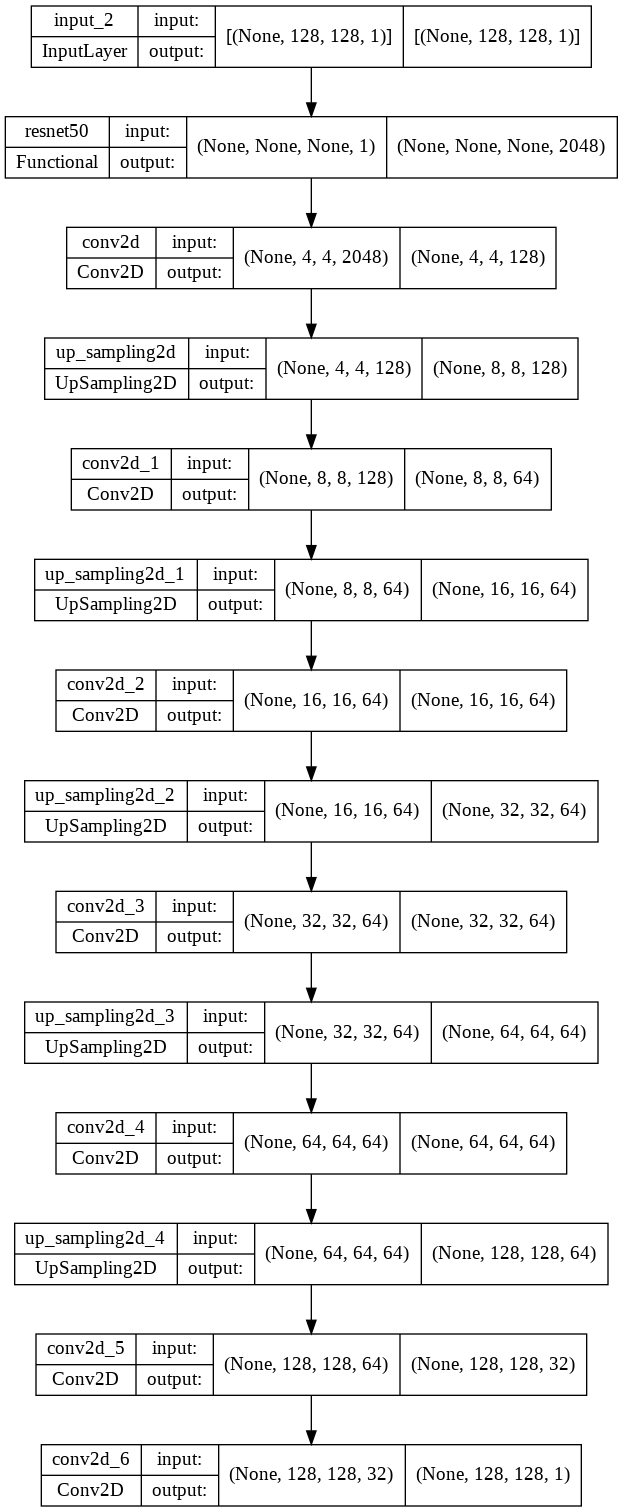

In [27]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [28]:
try:
  del history
except:
  pass
model = get_model(activation="tanh", loss=info["loss"])

### Model training
We train for a few epochs, saving weights of best epoch.



In [29]:
import skimage.filters
smoother = lambda x: (skimage.filters.gaussian(x, sigma=(0, 4, 4, 0), mode="wrap") + np.random.uniform(0, 0.25, size=x.shape))

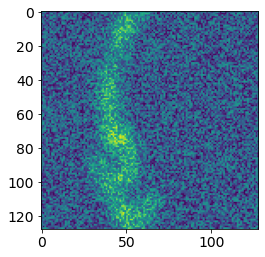

In [30]:
plt.imshow(smoother(y_train[:1])[0, :, :, 0])

(array([2436., 2580., 2750., 2852., 2874., 1956.,  497.,  308.,  114.,
          17.]),
 array([6.35239760e-06, 4.49850502e-02, 8.99637479e-02, 1.34942446e-01,
        1.79921143e-01, 2.24899841e-01, 2.69878539e-01, 3.14857237e-01,
        3.59835935e-01, 4.04814632e-01, 4.49793330e-01]),
 <a list of 10 Patch objects>)

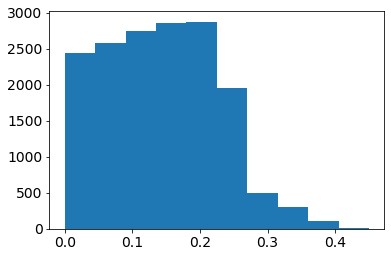

In [31]:
plt.hist(smoother(y_train[:1])[0, :, :, 0].reshape(-1))

In [32]:
checkpoint_filepath = BASEDIR / "output" / model_name / "checkpoints" 

In [33]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True,
        ),
]

In [34]:
history = model.fit(
    X_train, smoother(y_train),
    validation_data = (X_validation, smoother(y_validation)),
    epochs=max_epochs,
    callbacks=callbacks,
)
try:
  history_df = pd.concat([history_df, pd.DataFrame(history.history)])
  history_df.index = range(len(history_df))
except:
  history_df = pd.DataFrame(history.history)

# save history df
history_df.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df.p")

Epoch 1/25
1240/1240 [==============================] - 156s 113ms/step - loss: 0.0158 - val_loss: 0.0063
Epoch 2/25
1240/1240 [==============================] - 139s 112ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 3/25
1240/1240 [==============================] - 139s 112ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 4/25
1240/1240 [==============================] - 138s 112ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 5/25
1240/1240 [==============================] - 139s 112ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 6/25
1240/1240 [==============================] - 139s 112ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 7/25
1240/1240 [==============================] - 137s 111ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 8/25
1240/1240 [==============================] - 139s 112ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 9/25
1240/1240 [==============================] - 137s 110ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 10/25
1240/1240 [=======================

### Model predictions
We load the best weights and do predictions

In [35]:
model.load_weights(checkpoint_filepath)

In [36]:
y_test_pred = model.predict(X_test)

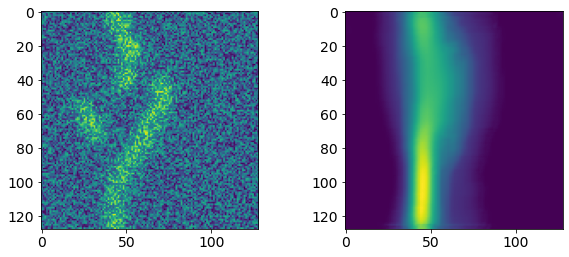

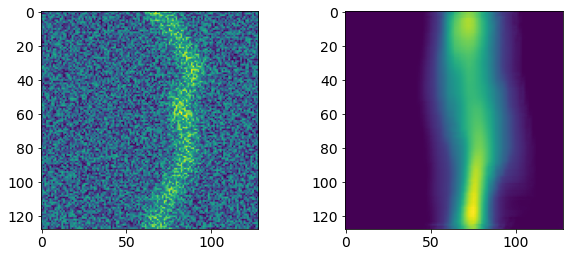

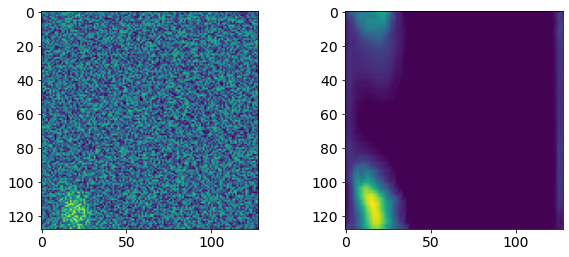

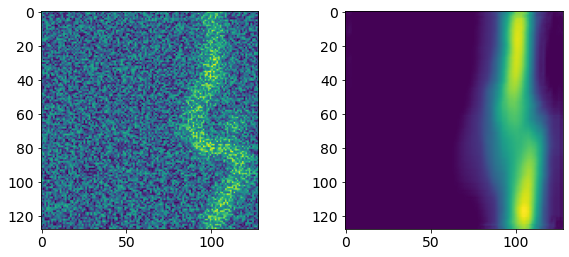

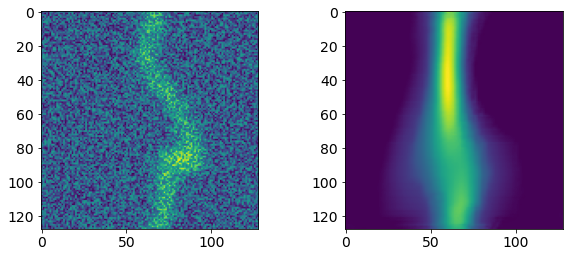

In [37]:
for im, im_pred in zip(smoother(y_test[:5]), y_test_pred[:5]):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.imshow(im[:, :, 0])
  ax2.imshow(im_pred[:, :, 0])


### Average Out Data Augmentation

In [38]:
def undo_DA(im, row):
  # guess image pixels carefully
  _px, _py, _ = im.shape
  assert _px == _py
  pixels = _px
  # undo flips on square image
  if  row["vertical_flip"]:
    im = np.flipud(im)
  if row["horizontal_flip"]:
    im = np.fliplr(im)
  # add nans on missing parts of lattice (left and right bands)
  pixels_to_add = round((row["box_size_x"] / row["box_size_y"] - 1) * pixels)
  pixels_to_add_left = pixels_to_add // 2
  pixels_to_add_right = pixels_to_add - pixels_to_add_left
  im = np.pad(im, pad_width=((0, 0), (pixels_to_add_left, pixels_to_add_right), (0, 0)),constant_values=np.nan)
  # undo translation carrying around missing part of image with nans
  tx = int(np.round(row["relative_translation_x"] * pixels))
  ty = int(np.round(row["relative_translation_y"] * pixels))
  im = np.roll(im, -tx, axis=1)
  im = np.roll(im, ty, axis=0)
  return im

In [39]:
X_test_noDA = []
y_test_noDA = []
y_test_pred_noDA = []
for _x, _y, _y_pred, (_, row) in zip(X_test, y_test, y_test_pred, df_test.iterrows()):
  X_test_noDA.append(undo_DA(_x, row))
  y_test_noDA.append(undo_DA(_y, row))
  y_test_pred_noDA.append(undo_DA(_y_pred, row))

In [40]:
df_test["np_order"] = np.arange(len(df_test))

In [41]:
X_test_noDA_nanmean = []
y_test_noDA_nanmean = []
y_test_pred_noDA_nanmean = []
y_test_pred_noDA_nanmedian = []
y_test_pred_noDA_nanmax = []
for lab, sdf in df_test.groupby("run"):
  _idx = sdf.np_order.values
  X_test_noDA_nanmean.append(np.nanmean(np.array([X_test_noDA[i] for i in _idx]), axis=0))
  y_test_noDA_nanmean.append(np.nanmean(np.array([y_test_noDA[i] for i in _idx]), axis=0))
  y_test_pred_noDA_nanmean.append(np.nanmean(np.array([y_test_pred_noDA[i] for i in _idx]), axis=0))  
  y_test_pred_noDA_nanmedian.append(np.nanmedian(np.array([y_test_pred_noDA[i] for i in _idx]), axis=0))  
  y_test_pred_noDA_nanmax.append(np.nanmax(np.array([y_test_pred_noDA[i] for i in _idx]), axis=0))  
  

In [42]:
target_predictions_dir = (BASEDIR / "output" / model_name / "figures" / "target-prediction")

In [43]:
! mkdir {str(target_predictions_dir)}

In [44]:
for i, (lab, _) in list(enumerate(df_test.groupby("run")))[:16]:
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
  ax1.imshow(y_test_noDA_nanmean[i][:, :, 0])
  ax1.set_title(f"Target {lab}")
  ax2.set_title(f"Mean Prediction {lab}")
  ax2.imshow(y_test_pred_noDA_nanmean[i][:, :, 0])

  ax3.set_title(f"Median Prediction {lab}")
  ax3.imshow(y_test_pred_noDA_nanmedian[i][:, :, 0])

  ax4.set_title(f"Max Prediction {lab}")
  ax4.imshow(y_test_pred_noDA_nanmax[i][:, :, 0])

  fig.savefig(target_predictions_dir / f"target-prediction-{lab}.png", dpi=150)

Output hidden; open in https://colab.research.google.com to view.

### Save test results

In [45]:
pd.to_pickle(y_test_pred, BASEDIR / "output" / model_name / "dataframes" / "y_test_pred.p")

In [46]:
pd.to_pickle(
  {
    "X_test_noDA": X_test_noDA,
    "y_test_noDA": y_test_noDA,
    "y_test_pred_noDA": y_test_pred_noDA
  },
  BASEDIR / "output" / model_name / "dataframes" / "noDA_lists.p"
)

### Save train results